In [1]:
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook

import warnings
warnings.filterwarnings(action='ignore')

import sys
sys.path.append('../stimulus_core/')
sys.path.append('../models_core/')
sys.path.append('../helper/')

import os
import numpy as np
import tensorflow as tf
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
import seaborn as sns
from  matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R3d
import imageio
import time
import importlib
import glob
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from scipy.spatial import distance_matrix, distance
from scipy.cluster import hierarchy
from PIL import Image
from time import sleep
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

import dynamics_3d as dn3d
import optical_signal as opsg
import predefined_weights as pdwt
import samples_generation_multi_units as smgnmu
import flow_field as flfd
import helper_functions as hpfn
import get_Klapoetke_stimuli as gKs

In [2]:
figure_path = '/Volumes/Baohua/research/loom_detection/results/revision/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    

# Model Clustering

Here, we cluster the model with respective the trained excitatory and inhibitory weights.

In [8]:
# Generate folders that will store the results of the clustering

has_inhibition = False
save_path = figure_path+'model_clustering_with_half_noise_rot_ln_scal200/'
if not os.path.exists(save_path+'trained_filters/'):
    os.makedirs(save_path+'trained_filters/')
if not os.path.exists(save_path+'clusterings/'):
    os.makedirs(save_path+'clusterings/')
if not os.path.exists(save_path+'auc_scores/'):
    os.makedirs(save_path+'auc_scores/')

In [72]:
# Load the data, one needs to change M that represents number of units in the model

M = 256
# result_folder = '/Volumes/Baohua/research_large_files/multi_lplc2_training_D5_i2/\
# set_{}_R1.0/inhibitory2/ACT_0_0.001/'.format(np.int(1000+M))
result_folder = f'/Volumes/Baohua/research_large_files/loom_detection/multi_lplc2_training_D5_exp_ln_relu_with_half_constant_rot_scal200/\
M_{M}/lr_0.001/regu_0.0001/'

subdir_all = []
for subdir, dirs, files in os.walk(result_folder):
    if os.path.exists(subdir+'/auc_roc.npy'):
        subdir_all.append(subdir)
    else:
        print(subdir)
filename = save_path+'clusterings/subdir_all_M{}'.format(M)
np.save(filename, subdir_all)


/Volumes/Baohua/research_large_files/loom_detection/multi_lplc2_training_D5_exp_ln_relu_with_half_constant_rot_scal200/M_256/lr_0.001/regu_0.0001/


In [73]:
# The hierachical clustering is used for the cluster.

effective_weights = np.concatenate((np.arange(4, 8), np.arange(14, 22), np.arange(25, 35), \
                                    np.arange(37, 47), np.arange(48, 72))) # for getting rid of corners
trained_weights_e_all = []
trained_weights_i_all = []
auc_scores = []
loss_output_all = []
y_scores = []
y_trues = []
for subdir in subdir_all:
    if os.path.exists(subdir+'/auc_roc.npy'):
        trained_weights_e = np.load(subdir+'/trained_weights_e.npy')
        auc_pr = np.load(subdir+'/auc_pr.npy')
        auc_roc = np.load(subdir+'/auc_roc.npy')
        y_score = np.load(subdir+'/y_pred_test.npy')
        y_true = np.load(subdir+'/y_true_test.npy')
        loss_output = np.load(subdir+'/train_loss_output.npy')
        trained_weights_e_all.append(trained_weights_e)
        auc_scores.append([auc_roc, auc_pr])
        y_scores.append(y_score)
        y_trues.append(y_true)
        loss_output_all.append(loss_output)
        if has_inhibition:
            trained_weights_i = np.load(subdir+'/trained_weights_i.npy')
            trained_weights_i_all.append(trained_weights_i)
    else:
        print(subdir)
trained_weights_e_all = np.array(trained_weights_e_all)[:, :, 0]
trained_weights_e_all_c = np.array(trained_weights_e_all)[:, effective_weights]
auc_scores = np.array(auc_scores)
y_scores = np.array(y_scores)
y_trues = np.array(y_trues)
loss_output_all = np.array(loss_output_all)
if has_inhibition:
    trained_weights_i_all = np.array(trained_weights_i_all)[:, :, 0]
    trained_weights_i_all_c = np.array(trained_weights_i_all)[:, effective_weights]
    trained_weights_all_c = np.concatenate((trained_weights_e_all_c, trained_weights_i_all_c), axis=1)
else:
    trained_weights_all_c = trained_weights_e_all_c

cos_similarity = cosine_similarity(trained_weights_all_c, trained_weights_all_c)
cos_similarity = np.clip(cos_similarity, 0., 1.)
cos_distance = 1-cos_similarity

trained_weights_all_s = np.zeros_like(trained_weights_all_c)
for ii in range(trained_weights_all_c.shape[0]):
    trained_weights_all_s[ii, :] = trained_weights_all_c[ii, :]+1e-30

threshold = 0.2
Z = hierarchy.linkage(trained_weights_all_s[:, :], metric='cosine')
C = hierarchy.fcluster(Z, threshold, criterion="distance")
print(np.unique(C))
NC = len(np.unique(C))

[1 2 3 4 5 6]


Cluster label:  1 Cluster size:  6


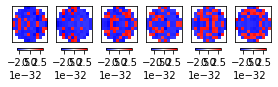

Cluster label:  2 Cluster size:  25


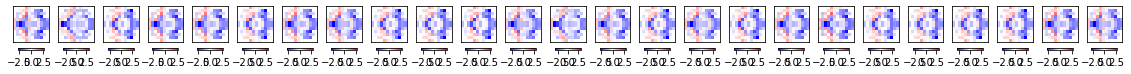

Cluster label:  3 Cluster size:  32


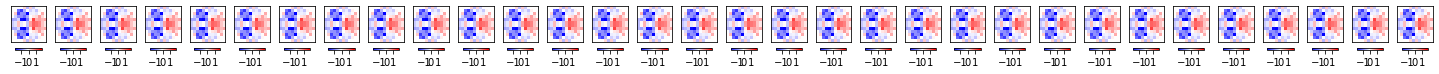

Cluster label:  4 Cluster size:  8


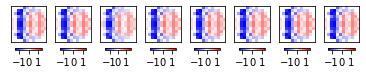

Cluster label:  5 Cluster size:  28


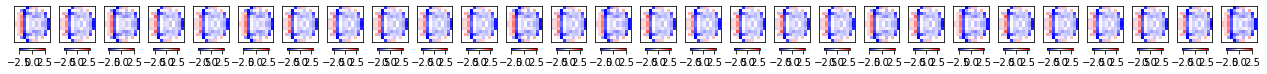

Cluster label:  6 Cluster size:  1


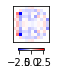

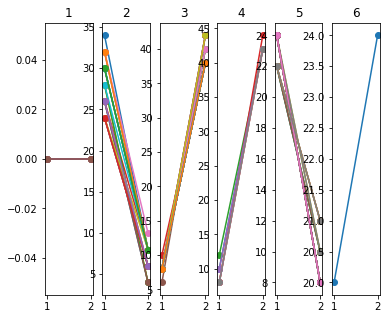

In [74]:
# Visualize the clustered weights to examine them by eyes.

importlib.reload(hpfn)

K = 12
n_sample = 50 # the largest number of sample weights to show for each cluster
mask_d = opsg.get_disk_mask(K, 4)
if has_inhibition:
    colormap_e = LinearSegmentedColormap.from_list('wr', ['w', 'r'], N=256)
else:
    colormap_e = LinearSegmentedColormap.from_list('bwr', ['b', 'w', 'r'], N=256)
colormap_i = LinearSegmentedColormap.from_list('wb', ['w', 'b'], N=256)
for label in range(1, NC+1):
    print('Cluster label: ', label, 'Cluster size: ', (C==label).sum())
    sample_array = np.where(C==label)[0]
    sample_list = list(sample_array[:n_sample])
    fig = hpfn.display_weights(K, trained_weights_e_all, trained_weights_i_all, has_inhibition, sample_list, n_sample, mask_d, colormap_e, colormap_i)
    filename = save_path+'trained_filters/filters_M{}_{}.pdf'.format(M, label)
    fig.savefig(filename, bbox_inches='tight')
    
    
# check left and right half of the filters
left_right_compare = np.zeros(len(C))
left_right_compare_unique = np.zeros(NC)
fig = plt.figure(figsize=(NC, 5))
gs0 = gridspec.GridSpec(1, NC, figure=fig)
for label in range(1, NC+1):
    sample_array = np.where(C==label)[0]
    sample_list = list(sample_array[:])
    for sample in sample_list:
        trained_weight_e = trained_weights_e_all[sample].reshape((K, K))
        trained_weight_e[mask_d] = 0
#         trained_weight_e[trained_weight_e<1e-3] = 0
        trained_weight_e_left = (trained_weight_e[:, :6]>1e-2).sum()
        trained_weight_e_right = (trained_weight_e[:, 6:]>1e-2).sum()
#         trained_weight_e_left = trained_weight_e[:, :6].sum()
#         trained_weight_e_right = trained_weight_e[:, 6:].sum()
        if trained_weight_e_left == trained_weight_e_right:
            left_right_compare[sample] = -1
        elif trained_weight_e_left < trained_weight_e_right:
            left_right_compare[sample] = 1
        elif trained_weight_e_left > trained_weight_e_right:
            left_right_compare[sample] = 0
        ax = fig.add_subplot(gs0[0, label-1])
        ax.plot([1, 2], [trained_weight_e_left, trained_weight_e_right], 'o-')
        ax.set_title(label)
    left_right_compare_unique[label-1] = np.round(left_right_compare[sample_list].mean())

In [75]:
# Check the model cluster size: 1--outward, 0--inward, -1--unstructured

print(f'Outward: {(left_right_compare == 1).sum()}')
print(f'Inward: {(left_right_compare == 0).sum()}')
print(f'Unstructured: {(left_right_compare == -1).sum()}')

Outward: 41
Inward: 53
Unstructured: 6


In [76]:
# 'm': outward; 'g': inward; 'k': others/unstructured

color_dict_tem = {}
color_dict_tem[1] = 'm'
color_dict_tem[0] = 'g'
color_dict_tem[-1] = 'k'

color_list = [color_dict_tem[ii] for ii in list(left_right_compare)]
color_list_unique = [color_dict_tem[ii] for ii in list(left_right_compare_unique)]
# print(color_list)
# print(color_list_unique)

In [77]:
# save the clustering results

# trained weights for clustering
filename = save_path+'clusterings/trained_weights_all_c_M{}'.format(M)
np.save(filename, trained_weights_all_c)

# hierarchical linkage
filename = save_path+'clusterings/Z_M{}'.format(M)
np.save(filename, Z)

# clusters
filename = save_path+'clusterings/C_M{}'.format(M)
np.save(filename, C)

# color list
filename = save_path+'clusterings/color_list_M{}'.format(M)
np.save(filename, color_list)

# color list unique
filename = save_path+'clusterings/color_list_unique_M{}'.format(M)
np.save(filename, color_list_unique)

# label dict
label_dict = {}
label_dict['m'] = []
label_dict['g'] = []
label_dict['k'] = []
for jj in range(len(C)):
    if color_list[jj] == 'm':
        label_dict['m'].append(jj)
    elif color_list[jj] == 'g':
        label_dict['g'].append(jj)
    elif color_list[jj] == 'k':
        label_dict['k'].append(jj)
filename = save_path+'clusterings/label_dict_M{}'.format(M)
np.save(filename, label_dict)

# the cluster size
total_cases = len(C)
outward_cases = len(label_dict['m'])
inward_cases = len(label_dict['g'])
cluster_size = np.array([M, total_cases, outward_cases, inward_cases])
filename = save_path+'clusterings/cluster_size_M{}'.format(M)
np.save(filename, cluster_size)
print('The M value is: ', M)
print('Total cases are: ', total_cases)
print('The number of outward cases are: ', outward_cases)
print('The number of inward cases are: ', inward_cases)

# model folders
model_folders_outward = []
model_folders_inward = []
model_folders_others = []
for jj in range(len(C)):
    if color_list[jj] == 'm':
        model_folders_outward.append(subdir_all[jj])
    elif color_list[jj] == 'g':
        model_folders_inward.append(subdir_all[jj])
    elif color_list[jj] == 'k':
        model_folders_others.append(subdir_all[jj])
model_folders = [model_folders_outward, model_folders_inward, model_folders_others]
filename = save_path+'clusterings/model_folders_M{}'.format(M)
np.save(filename, model_folders)

The M value is:  256
Total cases are:  100
The number of outward cases are:  41
The number of inward cases are:  53


In [78]:
# save the auc scores
auc_scores_outward = auc_scores[label_dict['m'], :]
auc_scores_inward = auc_scores[label_dict['g'], :]
filename = save_path+'auc_scores/auc_scores_M{}'.format(M)
np.save(filename, auc_scores)
filename = save_path+'auc_scores/auc_scores_outward_M{}'.format(M)
np.save(filename, auc_scores_outward)
filename = save_path+'auc_scores/auc_scores_inward_M{}'.format(M)
np.save(filename, auc_scores_inward)

# save the y scores
y_scores_outward = y_scores[label_dict['m'], :]
y_scores_inward = y_scores[label_dict['g'], :]
filename = save_path+'auc_scores/y_scores_M{}'.format(M)
np.save(filename, y_scores)
filename = save_path+'auc_scores/y_scores_outward_M{}'.format(M)
np.save(filename, y_scores_outward)
filename = save_path+'auc_scores/y_scores_inward_M{}'.format(M)
np.save(filename, y_scores_inward)

# save the y trues
y_trues_outward = y_trues[label_dict['m'], :]
y_trues_inward = y_trues[label_dict['g'], :]
filename = save_path+'auc_scores/y_trues_M{}'.format(M)
np.save(filename, y_trues)
filename = save_path+'auc_scores/y_trues_outward_M{}'.format(M)
np.save(filename, y_trues_outward)
filename = save_path+'auc_scores/y_trues_inward_M{}'.format(M)
np.save(filename, y_trues_inward)